In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 07 06:48 2019
Modified on Tue Nov 23 11:10 2021

@author: yuming
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from matplotlib import mlab
from astropy.io import fits
from astropy.coordinates import SkyCoord
from pathlib import Path
from dustmaps.planck import PlanckGNILCQuery
# from dustmaps.planck import PlanckQuery

In [2]:
outpath = './output/'
Path(outpath).mkdir(exist_ok=True)

In [3]:
def _check_range(rng, allowed):
    if rng is None:
        rng = allowed
    else:
        if not hasattr(rng, '__len__'):
            raise ValueError("range object does not have len() method")

        if rng[0] < allowed[0] or rng[1] > allowed[1]:
            raise ValueError("lon_range should be within [%s,%s]" % allowed)
    return rng


def randsphere(num, ra_range=None, dec_range=None, system='eq'):
    """
    Generate random points on the sphere
    You can limit the range in ra and dec.  To generate on a spherical cap, see
    randcap()
    parameters
    ----------
    num: integer
        The number of randoms to generate
    ra_range: list, optional
        Should be within range [0,360].  Default [0,360]
    dec_range: list, optional
        Should be within range [-90,90].  Default [-90,90]
    system: string
        Default is 'eq' for the ra-dec system.  Can also be 'xyz'.
    output
    ------
        for system == 'eq' the return is a tuple
            ra,dec = randsphere(...)
        for system == 'xyz' the return is a tuple
            x,y,z = randsphere(...)
    examples
    --------
        ra,dec = randsphere(2000, ra_range=[10,35], dec_range=[-25,15])
        x,y,z = randsphere(2000, system='xyz')
    """

    ra_range = _check_range(ra_range, [0.0, 360.0])
    dec_range = _check_range(dec_range, [-90.0, 90.0])

    ra = np.random.random(num)  # 0-1之间的随机数array
    ra *= (ra_range[1] - ra_range[0])
    if ra_range[0] > 0:
        ra += ra_range[0]

    # number [-1,1)
    cosdec_min = np.cos(np.deg2rad(90.0 + dec_range[0]))
    cosdec_max = np.cos(np.deg2rad(90.0 + dec_range[1]))
    v = np.random.random(num)
    v *= (cosdec_max - cosdec_min)
    v += cosdec_min

    np.clip(v, -1.0, 1.0, v)
    # Now this generates on [0,pi)
    dec = np.arccos(v)
    # convert to degrees
    # rad2deg(dec,dec)
    dec = np.rad2deg(dec)
    # now in range [-90,90.0)
    dec -= 90.0

    c1 = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')
    c2 = SkyCoord(l=ra * u.degree, b=dec * u.degree, frame='galactic')
    # if system == 'xyz':
    #     # x,y,z = eq2xyz(ra, dec)
    #     # return x,y,z
    #     return ra, dec
    # else:
    #     return ra, dec
#    return ra, dec
    if system == 'gal':
        return c2
    else:
        return c1

### 改动 关于第二步mock good的星等限制
第一步error的判据只用j，  
第二步mag limit的判据中，只用j，但是对于k和h band不符合限制的源，把他们的k和h band mag设置成nan

In [4]:
class BtstrpMock:
    
    def __init__(self):
        self.mocklist=[]   #存放每个随机数种子mock并筛优后的dataframe 
        self.copy=None
        self.ebv=None
        self.copy_good=None
        self.concat=None
        self.mockgood=None
        self.source=None
        self.selection_rate_list=[]
    
        
    def mocking(self,source=None,df1_good=None,rounds=5):
        
        self.source=source
        
        for i in range(rounds):
            np.random.seed(i+1000)
            self.copy = df1_good.copy()

            c = randsphere(len(self.copy), [0.0, 360.0], [-5,5], system='gal')
            ceq = c.transform_to('icrs')

            self.ebv = pd.DataFrame({'ebv': planck(ceq)})


            self.copy['ra'] = ceq.ra.deg
            self.copy['dec'] = ceq.dec.deg
            self.copy['l'] = c.l.deg
            self.copy['b'] = c.b.deg


            self.copy['ebv'] = self.ebv # 问题在这里，应该是index的问题

            for b in bands:  # 加上指定位置处的消光后的星等
                db = 'd' + b
                if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
                    self.copy[b] = self.copy[db] + self.copy['ebv'] * ec[b[0]]  
                if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
                    self.copy[b] = self.copy[db] + self.copy['ebv'] * ec[b[0].upper()]                                        
                if b[0] == 'w':
                    self.copy[b] = self.copy[db] + self.copy['ebv'] * ec[b[0].upper()+b[1]]

            self.copy_good = self.copy.query("ip <= 23.1\
                                    and zp <= 22.3\
                                    and yp <= 21.3\
                                    and jap<= 19.9")
            self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
            self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
            
            self.selection_rate_list.append(len(self.copy_good)/len(self.copy))

            self.mocklist.append(self.copy_good)

            if i == 0:
                self.concat = self.copy_good
                self.mockgood = self.concat.drop_duplicates(subset=['source_id'],keep='first')
            if i >= 1:
                self.concat = pd.concat([self.mockgood,self.copy_good])
                self.mockgood = self.concat.drop_duplicates(subset=['source_id'],keep='first')
            
            print(len(self.mockgood))
            
        self.mockgood.to_csv(outpath+'GoodMockGPQNIR_encap_'+str(rounds)+'.csv', index=False)
        # self.mockgood.to_csv(outpath+self.source+'MockGPQNIR_encap_'+str(rounds)+'.csv', index=False)

# 1. 整合两个数据集, 构成GoodQSO

In [6]:
tb = Table.read("/cargo/public/catdata/gpq_nir/refined_gdr3qsoc_20230115_v1_new_ULAS.fits",character_as_bytes=False)
tb_select = tb[['source_id','ra','dec','redshift_qsoc',
'snrW1pm','snrW2pm','W1mproPM','W2mproPM',
'g_mean_psf_mag','r_mean_psf_mag','i_mean_psf_mag','z_mean_psf_mag','y_mean_psf_mag',
'g_mean_psf_mag_error','r_mean_psf_mag_error','i_mean_psf_mag_error','z_mean_psf_mag_error','y_mean_psf_mag_error',
'yAperMag3','j_1AperMag3','hAperMag3','kAperMag3',
'yAperMag3Err','j_1AperMag3Err','hAperMag3Err','kAperMag3Err',
'pmRA_x','pmDE','e_pmRA','e_pmDE']]
df=tb_select.to_pandas()
coord = SkyCoord(ra=df.ra.values*u.deg,
                 dec=df.dec.values*u.deg,
                 frame='icrs')

df['l'] = coord.galactic.l.deg
df['b'] = coord.galactic.b.deg
df_good = df.query("snrW1pm > 5 and snrW2pm > 3\
and W1mproPM > 8 and W2mproPM > 7\
and i_mean_psf_mag >= 14\
and z_mean_psf_mag > 0\
and y_mean_psf_mag > 0\
and j_1AperMag3Err < 0.2171\
and i_mean_psf_mag_error < 0.2171"
)

df1_good = df_good.rename(columns={'g_mean_psf_mag':'gp','r_mean_psf_mag':'rp','i_mean_psf_mag':'ip',
                                   'z_mean_psf_mag':'zp','y_mean_psf_mag':'yp',
                         'yAperMag3':'yap','j_1AperMag3':'jap','hAperMag3':'hap','kAperMag3':'kap',
                        'W1mproPM':'w1vega','W2mproPM':'w2vega'},inplace=False)

df1_good.eval('w1ab=w1vega+2.699',inplace=True)
df1_good.eval('w2ab=w2vega+3.339',inplace=True)
df1_good.eval('yab=yap+0.634',inplace=True)
df1_good.eval('jab=jap+0.938',inplace=True)
df1_good.eval('hab=hap+1.379',inplace=True)
df1_good.eval('kab=kap+1.900',inplace=True)

df1_good.reset_index(inplace=True, drop=True)

df1_good.eval('o_ra=ra', inplace=True)
df1_good.eval('o_dec=dec', inplace=True)
df1_good.eval('o_l=l', inplace=True)
df1_good.eval('o_b=b', inplace=True)
df1_good.eval('o_g=gp', inplace=True)
df1_good.eval('o_r=rp', inplace=True)
df1_good.eval('o_i=ip', inplace=True)
df1_good.eval('o_z=zp', inplace=True)
df1_good.eval('o_y=yp', inplace=True)
### Also for UKIDSS bands
df1_good.eval('o_yap=yap',inplace=True)
df1_good.eval('o_jap=jap',inplace=True)
df1_good.eval('o_hap=hap',inplace=True)
df1_good.eval('o_kap=kap',inplace=True)
df1_good.eval('o_jab=jab',inplace=True)
df1_good.eval('o_hab=hab',inplace=True)
df1_good.eval('o_kab=kab',inplace=True)
### For Catwise2020
df1_good.eval('o_w1vega=w1vega', inplace=True)
df1_good.eval('o_w2vega=w2vega', inplace=True)
df1_good.eval('o_w1ab=w1ab', inplace=True)
df1_good.eval('o_w2ab=w2ab', inplace=True)

c_ori = SkyCoord(ra=df1_good['o_ra'].values * u.degree,
                 dec=df1_good['o_dec'].values * u.degree, frame='icrs')
planck = PlanckGNILCQuery()
df1_good['o_ebv'] = planck(c_ori)  # 原来位置的色余

df1_good.to_csv('/cargo/public/catdata/gpq_nir/gaiadr3qsoc_goodqso.csv',index=False)

In [7]:
tb2 = Table.read("/cargo/public/catdata/dr16q/dr16q_prop_clean_litesdssxPxWxGDR3xU.fits",character_as_bytes=False)
tb2_select = tb2[['RA','DEC','source_id','Z_DR16Q','EBV',
                  'snrW1pm','snrW2pm','W1mproPM','W2mproPM',
                'gmag','rmag','imag','zmag','ymag','e_gmag','e_rmag','e_imag','e_zmag','e_ymag',
                 'yAperMag3','j_1AperMag3','hAperMag3','kAperMag3',
                'yAperMag3Err','j_1AperMag3Err','hAperMag3Err','kAperMag3Err',
                'pmRA_s','pmDE_s','e_pmRA_s','e_pmDE_s' ]]
df2 = tb2_select.to_pandas()

coord = SkyCoord(ra=df2.RA.values*u.deg,
                 dec=df2.DEC.values*u.deg,
                 frame='icrs')

df2['l'] = coord.galactic.l.deg
df2['b'] = coord.galactic.b.deg
df2_good = df2.query('snrW1pm > 5 and snrW2pm > 3\
        and W1mproPM > 8 and W2mproPM > 7\
        and zmag > 0\
        and ymag > 0\
        and j_1AperMag3Err < 0.2171\
        and e_imag < 0.2171')

df2_good.rename(columns={'RA':'ra','DEC':'dec','gmag':'gp','rmag':'rp','imag':'ip',
                                   'zmag':'zp','ymag':'yp',
                         'yAperMag3':'yap','j_1AperMag3':'jap','hAperMag3':'hap','kAperMag3':'kap',
                        'W1mproPM':'w1vega','W2mproPM':'w2vega'},inplace=True)

df2_good.eval('w1ab=w1vega+2.699',inplace=True)
df2_good.eval('w2ab=w2vega+3.339',inplace=True)
df2_good.eval('yab=yap+0.634',inplace=True)
df2_good.eval('jab=jap+0.938',inplace=True)
df2_good.eval('hab=hap+1.379',inplace=True)
df2_good.eval('kab=kap+1.900',inplace=True)

df2_good.reset_index(inplace=True, drop=True)

df2_good.eval('o_ra=ra', inplace=True)
df2_good.eval('o_dec=dec', inplace=True)
df2_good.eval('o_l=l', inplace=True)
df2_good.eval('o_b=b', inplace=True)
df2_good.eval('o_g=gp', inplace=True)
df2_good.eval('o_r=rp', inplace=True)
df2_good.eval('o_i=ip', inplace=True)
df2_good.eval('o_z=zp', inplace=True)
df2_good.eval('o_y=yp', inplace=True)
## Also for UKIDSS bands
df2_good.eval('o_yap=yap',inplace=True)
df2_good.eval('o_jap=jap',inplace=True)
df2_good.eval('o_hap=hap',inplace=True)
df2_good.eval('o_kap=kap',inplace=True)
df2_good.eval('o_jab=jab',inplace=True)
df2_good.eval('o_hab=hab',inplace=True)
df2_good.eval('o_kab=kab',inplace=True)
### For Catwise2020
df2_good.eval('o_w1vega=w1vega', inplace=True)
df2_good.eval('o_w2vega=w2vega', inplace=True)
df2_good.eval('o_w1ab=w1ab', inplace=True)
df2_good.eval('o_w2ab=w2ab', inplace=True)

c_ori = SkyCoord(ra=df2_good['o_ra'].values * u.degree,
                 dec=df2_good['o_dec'].values * u.degree, frame='icrs')
planck = PlanckGNILCQuery()
df2_good['o_ebv'] = planck(c_ori)  # 原来位置的色余

df2_good.to_csv('/cargo/public/catdata/gpq_nir/dr16q_goodqso.csv',index=False)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-7-d43b9a9e11d9>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_good['o_ebv'] = planck(c_ori)  # 原来位置的色余


In [9]:
df1_good.shape

(81824, 59)

In [10]:
df2_good.shape

(95112, 60)

In [12]:
df0=pd.concat([df1_good,df2_good])
df0.reset_index(inplace=True, drop=True)

ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)
ec = ectb['rb']  # 消光系数
bands = ['gp', 'rp', 'ip', 'zp', 'yp',
         'yap', 'jap', 'hap','kap','yab','jab','hab','kab',
         'w1vega', 'w2vega', 'w1ab','w2ab']
for b in bands:  # 减去原来的位置处的消光后的星等
    db = 'd' + b
    if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
        df0[db] = df0[b] - df0['o_ebv'] * ec[b[0]]  
    if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
        df0[db] = df0[b] - df0['o_ebv'] * ec[b[0].upper()]                                        
    if b[0] == 'w':
        df0[db] = df0[b] - df0['o_ebv'] * ec[b[0].upper()+b[1]]
 

In [18]:
ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)
ectb

,abav,errabav,rb,rbsfd
g,1.155,0.009,3.5805,3.079230
r,0.843,0.006,2.6133,2.247438
i,0.628,0.004,1.9468,1.674248
z,0.487,0.003,1.5097,1.298342
y,0.395,0.003,1.2245,1.053070
J,0.235,0.004,0.7285,0.626510
H,0.135,0.006,0.4185,0.359910
K,0.073,0.004,0.2263,0.194618
W1,0.039,0.004,0.1209,0.103974
W2,0.026,0.004,0.0806,0.069316


In [14]:
df0_good = df0.query("ip <= 23.1\
            and zp <= 22.3\
            and yp <= 21.3\
            and jap<= 19.8")
df0_good.reset_index(inplace=True, drop=True)
df0_good

,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,rp,...,dhap,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab
0,2767321680207884800,0.005043,13.303750,1.773578,48.099998,58.799999,15.625000,14.462,19.437099,19.220200,...,NaN,17.052455,18.937881,19.059954,NaN,18.952454,15.616694,14.456463,18.315694,17.795464
1,2765772777561947520,0.010899,11.978308,2.605525,15.600000,14.000000,17.440001,16.209,20.990999,20.710100,...,18.954885,18.429144,20.089922,20.261206,20.333885,20.329144,17.427256,16.200503,20.126256,19.539504
2,2740011460641576192,0.011553,3.421437,0.565801,54.000000,48.799999,15.319000,14.589,20.939199,20.254700,...,17.237841,16.403263,19.264720,18.968871,18.616840,18.303262,15.314332,14.585888,18.013332,17.924887
3,2740013011126020864,0.012070,3.429246,0.792390,43.299999,48.900002,13.740000,12.695,19.964100,19.133801,...,16.184841,15.139262,18.338722,18.077870,17.563841,17.039263,13.735332,12.691888,16.434331,16.030888
4,2772105036825154944,0.019762,15.645914,0.614334,28.200001,24.100000,16.601000,15.567,20.665600,20.489500,...,18.563774,17.827359,20.462191,20.026087,19.942774,19.727358,16.593712,15.562142,19.292712,18.901142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175170,2738302682132584320,359.992559,0.861055,NaN,47.500000,56.700001,15.663000,14.375,19.364401,19.174400,...,17.272598,16.771753,18.609790,18.698673,18.651598,18.671753,15.659129,14.372419,18.358128,17.711420
175171,2765342627997010688,359.997704,10.564075,NaN,52.900002,65.199997,15.559000,14.218,19.511600,19.129000,...,17.145164,16.883867,18.885706,18.927065,18.524164,18.783866,15.550381,14.212254,18.249380,17.551255
175172,2747081938882826496,359.998774,8.751452,NaN,41.700001,47.599998,15.893000,14.662,19.528799,19.256100,...,17.242132,16.650176,18.588016,18.599934,18.621132,18.550175,15.886682,14.657788,18.585682,17.996788
175173,2738223521591531136,359.994688,0.562592,NaN,37.500000,31.200001,16.101999,15.163,19.477600,19.349300,...,17.781102,17.449486,19.162337,19.332808,19.160102,19.349485,16.097984,15.160323,18.796984,18.499324


In [15]:
df0_good.to_csv('/cargo/public/catdata/gpq_nir/goodqso.csv')

# 2. 模拟到正负五度天区，构建GoodMockGPQ

In [6]:
df0_good = pd.read_csv('/cargo/public/catdata/gpq_nir/goodqso.csv')

In [18]:
planck = PlanckGNILCQuery()
ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)

ec = ectb['rb']  # 消光系数
bands = ['gp', 'rp', 'ip', 'zp', 'yp',
         'yap', 'jap', 'hap','kap','yab','jab','hab','kab',
         'w1vega', 'w2vega', 'w1ab','w2ab']

In [16]:
mockQSO=BtstrpMock()
mockQSO.mocking(source='all', df1_good=df0_good,rounds=5)

<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

93320


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

129053


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

145019


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

153309


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

158048


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

161110


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

163085


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

164566


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

165637


<ipython-input-4-ab8025281232>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-4-ab8025281232>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

166535


In [ ]:
# planckGNILCQuery: 166535

# planck query: 171005

In [33]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

plt.rcParams["figure.figsize"] = (5,3) # 调整图片尺寸
plt.rcParams["figure.dpi"] = 120 # 提高图片分辨率

Text(0, 0.5, 'selection_rate of each round')

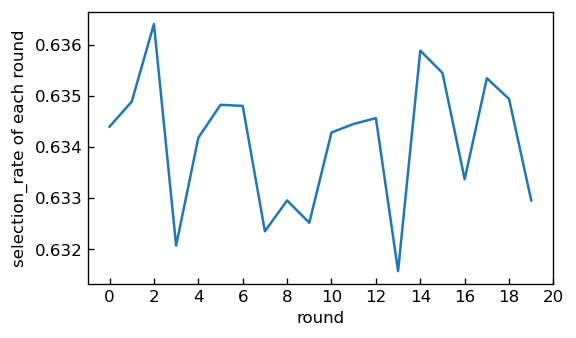

In [38]:
x = [i for i in range(20)]
y = mockQSO.selection_rate_list
plt.plot(x,y)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.xlabel('round')
plt.ylabel('selection_rate of each round')

# 3. 把两个qso数据集分别模拟到正负五度天区再合并（不用这个）

## 1. gaiadr3 qso candidate mocking

In [6]:
tb = Table.read("refined_gdr3qsoc_20230115_v1_new_ULAS.fits",character_as_bytes=False)

In [7]:
tb.columns  # 没找到kron mag

<TableColumns names=('source_id','ra','dec','redshift_qsoc','gr','ri','iz','zy','gw1','rw1','iw1','zw1','yw1','w12','bp_rp','bp_g','g_rp','bp_rp_ef','norm_pmra','norm_pmdec','norm_plx','fpm0','log_fpm0','AEN','AEN_sig','pred_class','p_qso','p_star','redshift_nn','solution_id','astrometric_selection_flag','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','structure_function_index','structure_function_index_scatter','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','ccfratio_qsoc','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','sersic_index','sersic_index_error','ellipticity_hostgalaxy','ellipticity_hostgalaxy_error','posangle_hostgalaxy

In [3]:
len(tb)

101587

In [4]:
tb_select = tb[['source_id','ra','dec','redshift_qsoc',
'snrW1pm','snrW2pm','W1mproPM','W2mproPM',
'g_mean_psf_mag','r_mean_psf_mag','i_mean_psf_mag','z_mean_psf_mag','y_mean_psf_mag',
'g_mean_psf_mag_error','r_mean_psf_mag_error','i_mean_psf_mag_error','z_mean_psf_mag_error','y_mean_psf_mag_error',
'yAperMag3','j_1AperMag3','hAperMag3','kAperMag3',
'yAperMag3Err','j_1AperMag3Err','hAperMag3Err','kAperMag3Err',
'pmRA_x','pmDE','e_pmRA','e_pmDE']]

In [5]:
df = tb_select.to_pandas()

In [14]:
df.ra.describe()

count    101587.000000
mean        177.405917
std          77.792190
min           0.005043
25%         144.483094
50%         188.387584
75%         212.519242
max         359.999088
Name: ra, dtype: float64

In [6]:
# 添加l,b两个columns

coord = SkyCoord(ra=df.ra.values*u.deg,
                 dec=df.dec.values*u.deg,
                 frame='icrs')

df['l'] = coord.galactic.l.deg
df['b'] = coord.galactic.b.deg

In [11]:
# select good subsets
df_good = df.query("snrW1pm > 5 and snrW2pm > 3\
and W1mproPM > 8 and W2mproPM > 7\
and i_mean_psf_mag >= 14\
and z_mean_psf_mag > 0\
and y_mean_psf_mag > 0\
and j_1AperMag3Err < 0.2171\
and i_mean_psf_mag_error < 0.2171"
)

In [12]:
df1_good = df_good.rename(columns={'g_mean_psf_mag':'gp','r_mean_psf_mag':'rp','i_mean_psf_mag':'ip',
                                   'z_mean_psf_mag':'zp','y_mean_psf_mag':'yp',
                         'yAperMag3':'yap','j_1AperMag3':'jap','hAperMag3':'hap','kAperMag3':'kap',
                        'W1mproPM':'w1vega','W2mproPM':'w2vega'},inplace=False)

In [13]:
# 做vega-ab转换
df1_good.eval('w1ab=w1vega+2.699',inplace=True)
df1_good.eval('w2ab=w2vega+3.339',inplace=True)
df1_good.eval('yab=yap+0.634',inplace=True)
df1_good.eval('jab=jap+0.938',inplace=True)
df1_good.eval('hab=hap+1.379',inplace=True)
df1_good.eval('kab=kap+1.900',inplace=True)

In [14]:
# 非常重要

df1_good.reset_index(inplace=True)

In [15]:
## 保留原来高银纬处的数据
df1_good.eval('o_ra=ra', inplace=True)
df1_good.eval('o_dec=dec', inplace=True)
df1_good.eval('o_l=l', inplace=True)
df1_good.eval('o_b=b', inplace=True)
df1_good.eval('o_g=gp', inplace=True)
df1_good.eval('o_r=rp', inplace=True)
df1_good.eval('o_i=ip', inplace=True)
df1_good.eval('o_z=zp', inplace=True)
df1_good.eval('o_y=yp', inplace=True)
### Also for UKIDSS bands
df1_good.eval('o_yap=yap',inplace=True)
df1_good.eval('o_jap=jap',inplace=True)
df1_good.eval('o_hap=hap',inplace=True)
df1_good.eval('o_kap=kap',inplace=True)
df1_good.eval('o_jab=jab',inplace=True)
df1_good.eval('o_hab=hab',inplace=True)
df1_good.eval('o_kab=kab',inplace=True)
### For Catwise2020
df1_good.eval('o_w1vega=w1vega', inplace=True)
df1_good.eval('o_w2vega=w2vega', inplace=True)
df1_good.eval('o_w1ab=w1ab', inplace=True)
df1_good.eval('o_w2ab=w2ab', inplace=True)

c_ori = SkyCoord(ra=df1_good['o_ra'].values * u.degree,
                 dec=df1_good['o_dec'].values * u.degree, frame='icrs')
planck = PlanckQuery()
df1_good['o_ebv'] = planck(c_ori)  # 原来位置的色余

In [16]:
# 消光系数的文件要update么(先不update以便和之前做比较)
ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)

ec = ectb['rb']  # 消光系数
bands = ['gp', 'rp', 'ip', 'zp', 'yp',
         'yap', 'jap', 'hap','kap','yab','jab','hab','kab',
         'w1vega', 'w2vega', 'w1ab','w2ab']

for b in bands:  # 减去原来的位置处的消光后的星等
    db = 'd' + b
    if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
        df1_good[db] = df1_good[b] - df1_good['o_ebv'] * ec[b[0]]  
    if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
        df1_good[db] = df1_good[b] - df1_good['o_ebv'] * ec[b[0].upper()]                                        
    if b[0] == 'w':
        df1_good[db] = df1_good[b] - df1_good['o_ebv'] * ec[b[0].upper()+b[1]]

In [18]:
mockQSO=BtstrpMock()
mockQSO.mocking(source='gaiadr3',df1_good=df1_good,rounds=10)

<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

44536


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

62307


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

70126


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

73986


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

76011


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

77176


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

77904


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

78381


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

78720


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

78976


In [ ]:
# 极限在八万左右。之后可以画一个模拟轮数的曲线

## 2. sdss dr16q mocking

In [19]:
tb2 = Table.read("/cargo/public/catdata/dr16q/dr16q_prop_clean_litesdssxPxWxGDR3xU.fits",character_as_bytes=False)

In [20]:
len(tb2)

121116

In [21]:
tb2.columns

# gmag_s是sdss mag，gmag是ps1的psfmag，gKmag是ps1的Kronmag

<TableColumns names=('SDSS_NAME','PLATE','MJD','FIBERID','RA','DEC','OBJID','IF_BOSS_SDSS','Z_DR16Q','SOURCE_Z_DR16Q','Z_FIT','Z_SYS','Z_SYS_ERR','EBV','SN_MEDIAN_ALL','FEII_UV_EW','FEII_UV_EW_ERR','FEII_OPT_EW','FEII_OPT_EW_ERR','LOGL1350','LOGL1350_ERR','LOGL1700','LOGL1700_ERR','LOGL3000','LOGL3000_ERR','LOGL5100','LOGL5100_ERR','LOGLBOL','LOGLBOL_ERR','LOGMBH_HB','LOGMBH_HB_ERR','LOGMBH_MGII','LOGMBH_MGII_ERR','LOGMBH_CIV','LOGMBH_CIV_ERR','LOGMBH','LOGMBH_ERR','LOGLEDD_RATIO','LOGLEDD_RATIO_ERR','objID_x','RA_ICRS','DE_ICRS','errHalfMaj','errHalfMin','errPosAng','mode','class','clean','e_RA_ICRS','e_DE_ICRS','umag','gmag_s','rmag_s','imag_s','zmag_s','e_umag','e_gmag_s','e_rmag_s','e_imag_s','e_zmag_s','zsp','e_zsp','f_zsp','spCl','subCl','pmRA_s','pmDE_s','e_pmRA_s','e_pmDE_s','sigRA','sigDE','zph','e_zph','zph2','Q','SDSS16','Sp-ID','MJD_x','angDist','objID_p','RAJ2000','DEJ2000','errHalfMaj_p','errHalfMin_p','errPosAng_p','f_objID','Qual','Epoch','Ns','Nd','gmag','e_gmag','gKma

In [22]:
tb2_select = tb2[['RA','DEC','source_id','Z_DR16Q','EBV',
                  'snrW1pm','snrW2pm','W1mproPM','W2mproPM',
                'gmag','rmag','imag','zmag','ymag','e_gmag','e_rmag','e_imag','e_zmag','e_ymag',
                 'yAperMag3','j_1AperMag3','hAperMag3','kAperMag3',
                'yAperMag3Err','j_1AperMag3Err','hAperMag3Err','kAperMag3Err',
                'pmRA_s','pmDE_s','e_pmRA_s','e_pmDE_s' ]]

In [23]:
df2 = tb2_select.to_pandas()

In [24]:
# 添加l,b两个columns

coord = SkyCoord(ra=df2.RA.values*u.deg,
                 dec=df2.DEC.values*u.deg,
                 frame='icrs')

df2['l'] = coord.galactic.l.deg
df2['b'] = coord.galactic.b.deg

In [25]:
df2.imag.describe()
# 看起来imag都大于14，也就不用在query那一步筛选了

count    121008.000000
mean         19.800505
std           0.826058
min          15.117700
25%          19.263901
50%          19.952200
75%          20.438499
max          22.281700
Name: imag, dtype: float64

In [26]:
# select good subsets
df2_good = df2.query('snrW1pm > 5 and snrW2pm > 3\
        and W1mproPM > 8 and W2mproPM > 7\
        and zmag > 0\
        and ymag > 0\
        and j_1AperMag3Err < 0.2171\
        and e_imag < 0.2171')

# 在query这一步若加上条件'and imag>=14'会报错'unsupported object type: <class 'function'>'，暂时没弄清原因

In [27]:
df2_good = df2_good.rename(columns={'gmag':'gp','rmag':'rp','imag':'ip',
                                   'zmag':'zp','ymag':'yp',
                         'yAperMag3':'yap','j_1AperMag3':'jap','hAperMag3':'hap','kAperMag3':'kap',
                        'W1mproPM':'w1vega','W2mproPM':'w2vega'},inplace=False)

In [28]:
# 做vega-ab转换
df2_good.eval('w1ab=w1vega+2.699',inplace=True)
df2_good.eval('w2ab=w2vega+3.339',inplace=True)
df2_good.eval('yab=yap+0.634',inplace=True)
df2_good.eval('jab=jap+0.938',inplace=True)
df2_good.eval('hab=hap+1.379',inplace=True)
df2_good.eval('kab=kap+1.900',inplace=True)

In [29]:
# 非常重要

df2_good.reset_index(inplace=True)

In [30]:
## 保留原来高银纬处的数据
df2_good.eval('o_ra=RA', inplace=True)
df2_good.eval('o_dec=DEC', inplace=True)
df2_good.eval('o_l=l', inplace=True)
df2_good.eval('o_b=b', inplace=True)
df2_good.eval('o_g=gp', inplace=True)
df2_good.eval('o_r=rp', inplace=True)
df2_good.eval('o_i=ip', inplace=True)
df2_good.eval('o_z=zp', inplace=True)
df2_good.eval('o_y=yp', inplace=True)
## Also for UKIDSS bands
df2_good.eval('o_yap=yap',inplace=True)
df2_good.eval('o_jap=jap',inplace=True)
df2_good.eval('o_hap=hap',inplace=True)
df2_good.eval('o_kap=kap',inplace=True)
df2_good.eval('o_jab=jab',inplace=True)
df2_good.eval('o_hab=hab',inplace=True)
df2_good.eval('o_kab=kab',inplace=True)
### For Catwise2020
df2_good.eval('o_w1vega=w1vega', inplace=True)
df2_good.eval('o_w2vega=w2vega', inplace=True)
df2_good.eval('o_w1ab=w1ab', inplace=True)
df2_good.eval('o_w2ab=w2ab', inplace=True)

c_ori = SkyCoord(ra=df2_good['o_ra'].values * u.degree,
                 dec=df2_good['o_dec'].values * u.degree, frame='icrs')
planck = PlanckQuery()
df2_good['o_ebv'] = planck(c_ori)  # 原来位置的色余

In [31]:
df2_good[['EBV','o_ebv']]
# 差别有点大？反正模拟的时候还是用planck的

,EBV,o_ebv
0,0.075603,0.077685
1,0.035425,0.048503
2,0.028242,0.037025
3,0.045224,0.055921
4,0.048855,0.057596
...,...,...
95107,0.021893,0.032956
95108,0.067479,0.074315
95109,0.052758,0.058529
95110,0.022705,0.033949


In [32]:
# 消光系数的文件要update么(先不update以便和之前做比较)
ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)

ec = ectb['rb']  # 消光系数
bands = ['gp', 'rp', 'ip', 'zp', 'yp',
         'yap', 'jap', 'hap','kap','yab','jab','hab','kab',
         'w1vega', 'w2vega', 'w1ab','w2ab']

for b in bands:  # 减去原来的位置处的消光后的星等
    db = 'd' + b
    if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
        df2_good[db] = df2_good[b] - df2_good['o_ebv'] * ec[b[0]]  
    if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
        df2_good[db] = df2_good[b] - df2_good['o_ebv'] * ec[b[0].upper()]                                        
    if b[0] == 'w':
        df2_good[db] = df2_good[b] - df2_good['o_ebv'] * ec[b[0].upper()+b[1]]

In [33]:
mockQSO=BtstrpMock()
mockQSO.mocking(source='sdss',df1_good=df2_good,rounds=10)

<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

55503


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

75406


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

83639


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

87355


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

89225


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

90318


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

91018


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

91490


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

91856


<ipython-input-5-2ab0861ee698>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.hap[self.copy_good.hap>19.0]=np.nan
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-5-2ab0861ee698>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.copy_good.kap[self.copy_good.kap>18.8]=np.nan
/opt/anaconda3/lib/p

92120


In [ ]:
# 极限在九万多

## 3. concat two mock samples

In [36]:
gaiamock=pd.read_csv('./output/gaiadr3MockGPQNIR_encap_10.csv')
sdssmock=pd.read_csv('./output/sdssMockGPQNIR_encap_10.csv')

mockall=pd.concat([gaiamock,sdssmock])
mockall

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,EBV,e_gmag,e_rmag,e_imag,e_zmag,e_ymag,pmRA_s,pmDE_s,e_pmRA_s,e_pmDE_s
0,0,2767321680207884800,94.906211,13.212090,1.773578,48.1,58.8,15.681823,14.499882,21.119922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2740011460641576192,101.279557,-5.364670,0.565801,54.0,48.8,15.356488,14.613991,22.049408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2740013011126020864,98.446325,16.607371,0.792390,43.3,48.9,13.804439,12.737959,21.872490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2772105036825154944,62.410195,49.569883,0.614334,28.2,24.1,16.706771,15.637514,23.798040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2768962873110894208,111.823627,-17.492841,1.611916,14.7,14.9,17.523515,16.145011,24.014356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92115,119734,2739345367049380480,98.939591,11.814692,NaN,22.7,17.8,16.861329,16.027885,22.173908,...,0.018903,0.0205,0.0216,0.0133,0.0345,0.0643,1.29,-1.04,4.46,4.46
92116,119845,2739795166088538240,107.436118,-5.911205,NaN,24.7,19.5,16.839423,15.834282,22.175146,...,0.025020,0.0650,0.0658,0.0198,0.0550,0.1263,-6.12,28.79,7.75,7.75
92117,120180,2767308451708817408,123.762141,-33.995986,NaN,21.0,12.3,16.805742,16.216828,22.015840,...,0.037568,0.0425,0.0331,0.0338,0.0125,0.1344,0.00,0.00,0.00,0.00
92118,120458,2739588079945298944,124.172389,-27.400934,NaN,16.9,13.5,17.229635,16.174756,21.553024,...,0.020780,0.0300,0.0130,0.0396,0.1005,0.0704,0.00,0.00,0.00,0.00


In [37]:
mockall_drop = mockall.drop_duplicates()
mockall_drop # 没有变化，说明sdss和gaiadr3的源是没有重合的

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,EBV,e_gmag,e_rmag,e_imag,e_zmag,e_ymag,pmRA_s,pmDE_s,e_pmRA_s,e_pmDE_s
0,0,2767321680207884800,94.906211,13.212090,1.773578,48.1,58.8,15.681823,14.499882,21.119922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2740011460641576192,101.279557,-5.364670,0.565801,54.0,48.8,15.356488,14.613991,22.049408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2740013011126020864,98.446325,16.607371,0.792390,43.3,48.9,13.804439,12.737959,21.872490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2772105036825154944,62.410195,49.569883,0.614334,28.2,24.1,16.706771,15.637514,23.798040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2768962873110894208,111.823627,-17.492841,1.611916,14.7,14.9,17.523515,16.145011,24.014356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92115,119734,2739345367049380480,98.939591,11.814692,NaN,22.7,17.8,16.861329,16.027885,22.173908,...,0.018903,0.0205,0.0216,0.0133,0.0345,0.0643,1.29,-1.04,4.46,4.46
92116,119845,2739795166088538240,107.436118,-5.911205,NaN,24.7,19.5,16.839423,15.834282,22.175146,...,0.025020,0.0650,0.0658,0.0198,0.0550,0.1263,-6.12,28.79,7.75,7.75
92117,120180,2767308451708817408,123.762141,-33.995986,NaN,21.0,12.3,16.805742,16.216828,22.015840,...,0.037568,0.0425,0.0331,0.0338,0.0125,0.1344,0.00,0.00,0.00,0.00
92118,120458,2739588079945298944,124.172389,-27.400934,NaN,16.9,13.5,17.229635,16.174756,21.553024,...,0.020780,0.0300,0.0130,0.0396,0.1005,0.0704,0.00,0.00,0.00,0.00


In [39]:
mockall_drop.to_csv('./output/MockGPQNIR_encap_10.csv')